<a href="https://colab.research.google.com/github/alouwyck/vives-intro-to-ai/blob/main/topic10/topic10_3_Intro_LangChain_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

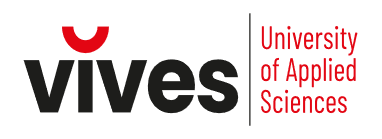<br>


**INTRODUCTION TO ARTIFICIAL INTELLIGENCE**<br>
VIVES BUSINESS ACADEMY<br>
Academic Year 2024-2025<br>
Andy Louwyck

---



---



# **Introduction to Retrieval-Augmented Generation with LangChain**

[LangChain](https://www.langchain.com/) is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots. These are applications that can answer questions about specific source information. These applications use a technique known as Retrieval-Augmented Generation, or RAG.

Basically, RAG is a technique for augmenting LLM knowledge with additional data. This notebook introduces some key LangChain concepts relevant to RAG and demonstrates their application in building simple RAG applications. Before diving into the code, it is explained in more detail what RAG is.


## **What is RAG?**

LLMs can reason about wide-ranging topics, but their knowledge is limited to the public data up to a specific point in time that they were trained on. If you want to build AI applications that can reason about private data or data introduced after a model's cutoff date, you need to augment the knowledge of the model with the specific information it needs. The process of bringing the appropriate information and inserting it into the model prompt is known as Retrieval-Augmented Generation, which is abbreviated as RAG.

LangChain has a number of components designed to help build Q&A applications, and RAG applications more generally. In this notebook, we focus on Q&A for unstructured data, but RAG over structured data, such as SQL data, is also possible.

A typical RAG application has two main components:

- *Indexing* : a pipeline for ingesting data from a source and indexing it. This usually happens offline.

- *Retrieval* and *generation* : the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

The most common full sequence from raw data to answer looks like:

**Indexing**

1. *Load* : First we need to load our data. This is done with document loaders.
2. *Split* : Text splitters break large documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won't fit in a model's finite context window.
3. *Store* : We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a vector store and an embeddings model.

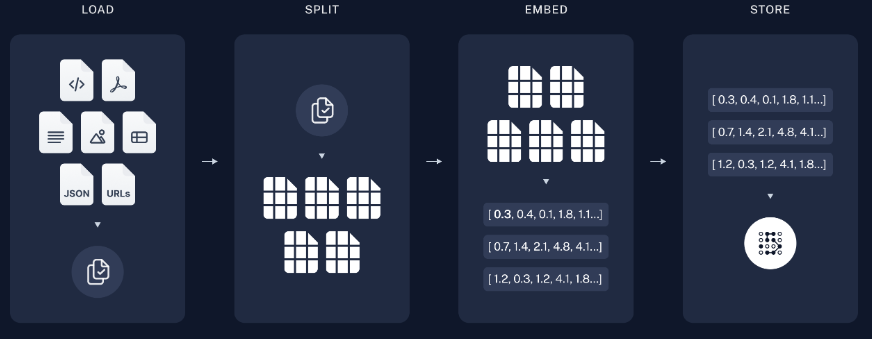

**Retrieval and generation**

4. *Retrieve* : Given a user input, relevant splits are retrieved from storage using a retriever.
5. *Generate* : A chat model or LLM produces an answer using a prompt that includes the question and the retrieved data.


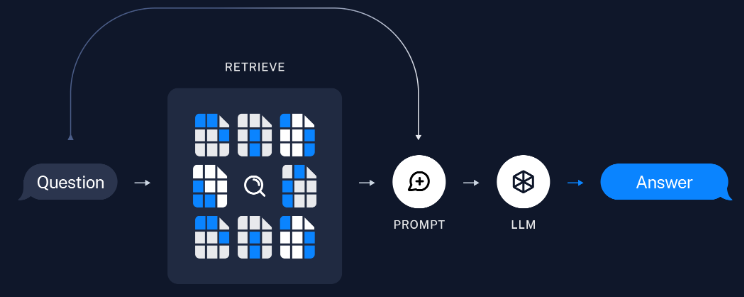

Step 3 applies an **Embedding model**, which creates a vector representation of a piece of text. You can think of a vector as an array of numbers that captures the semantic meaning of the text. By representing the text in this way, you can perform mathematical operations that allow you to do things like search for other pieces of text that are most similar in meaning. These natural language search capabilities underpin many types of context retrieval, where we provide an LLM with the relevant data it needs to effectively respond to a query.

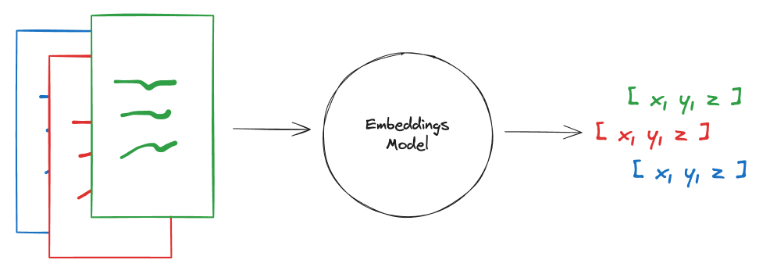

The created vectors are stored in a **vector store** or vector database. One of the most common ways to store and search over unstructured data is actually to embed it and store the resulting embedding vectors, and then at query time to embed the unstructured query and retrieve the embedding vectors that are 'most similar' to the embedded query. A vector store takes care of storing embedded data and performing vector search for you. Most vector stores can also store metadata about embedded vectors and support filtering on that metadata before similarity search, allowing you more control over returned documents.

LangChain includes a suite of integrations with different vector store technologies. Some vector stores are hosted by a provider (e.g., various cloud providers) and require specific credentials to use; some (such as Postgres) run in separate infrastructure that can be run locally or via a third-party; others can run in-memory for lightweight workloads. Here we will demonstrate usage of LangChain vector stores using `Chroma`, which includes an in-memory implementation.

## **Setup**

In this notebook, we will show how to build a simple Q&A application over a text data source. Along the way we'll go over a typical Q&A architecture. The code example is adopted and modified from the following LangChain tutorial, which requires `langchain` and `langchain-chroma`: https://python.langchain.com/v0.2/docs/tutorials/rag/.

Instead of using an embedding model by OpenAI as suggested by the tutorial, we'll apply the BGE model from HuggingFace, which is currently one of the best open-source embedding models: https://python.langchain.com/v0.2/docs/integrations/text_embedding/bge_huggingface/. That is why we also import `langchain-community` and `sentence_transformers`. To be able to load PDF-files, we need [PyMuPDF](https://pymupdf.readthedocs.io/en/latest/).

Because we'll build very simple RAG applications using [Llama3](https://en.wikipedia.org/wiki/Llama_(language_model)) from Meta AI, we also need to import `langchain-groq`. Of course, it is possible to use another LLM, such as one of OpenAI's [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer), Google's [Gemini](https://en.wikipedia.org/wiki/Gemini_(language_model)), Anthropic's [Claude](https://en.wikipedia.org/wiki/Claude_(language_model)), or the latest [mistral.ai](https://mistral.ai/) chat model. To see how you can setup another chat model, check https://python.langchain.com/v0.2/docs/tutorials/llm_chain/#setup. Note that [Groq](https://en.wikipedia.org/wiki/Groq) currently hosts a variety of open-source large language models running on its LPUs for public access. So if you opt for the Groq setup, you can use Llama at no cost.

In [1]:
!pip install -q langchain langchain-community langchain-chroma langchain-groq sentence_transformers pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.0 MB/s eta 0:00:

It is highly recommended to add your API tokens for LangChain and Groq to the Google Colab Secrets (left pain), and assign them to the following environment variables:

In [2]:
import os
from google.colab import userdata
for key in ['LANGCHAIN_API_KEY', 'GROQ_API_KEY', "HF_TOKEN"]:
    os.environ[key] = userdata.get(key)

Note that you also need a HuggingFace token in order to apply the BGE model.

Llama3 is instantiated as follows:

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")

Now you can start chatting with the LLM by calling method `invoke`:

In [3]:
llm.invoke('How are you?').content

'I\'m just a language model, I don\'t have feelings or emotions like humans do, so I don\'t have a personal experience of being "good" or "bad". I am simply a computer program designed to process and generate human-like text. I\'m functioning properly and ready to assist you with any questions or tasks you may have!'

## **Build a RAG App**

We are now ready to build a simple RAG application using the Llama3 LLM to generate answers to questions about the board games [Monopoly](https://en.wikipedia.org/wiki/Monopoly_(game)) and [Risk](https://en.wikipedia.org/wiki/Risk_(game)). On the internet, we find a PDF file with the rules in Dutch for each of these games. We will store these files in a Chroma vector store, which we will use as a retriever to provide specific content about the board games to the LLM. We expect the LLM to answer questions in English about the board games in Romanian.

### Step 1: Indexing - Load

First, we have to upload the two PDF-files explaining the rules of Monopoly and Risk:

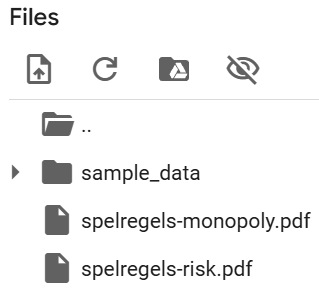

We load the PDF-files using LangChain's `PyMuPDFLoader`:

In [4]:
from langchain_community.document_loaders import PyMuPDFLoader

files = ['spelregels-monopoly.pdf',
         'spelregels-risk.pdf']
all_docs = []
for file in files:
    loader = PyMuPDFLoader(file)
    docs = loader.load()
    print(len(docs))
    all_docs.extend(docs)
print(len(all_docs))

2
6
8


### Step 2: Indexing - Split

Because our loaded documents are too long to fit in the context window of many models, we split them using the `RecursiveCharacterTextSplitter` in chunks of maximum 1000 characters with 200 characters of overlap between the chunks. The overlap helps mitigate the possibility of separating a statement from important context related to it.

Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs. This should help us retrieve only the most relevant bits of the documents.

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(all_docs)

len(all_splits)

47

So, we obtain 47 chunks. Let's check the minimum and maximum number of characters in these chunks:

In [6]:
print('min number of characters:', min(len(split.page_content) for split in all_splits))
print('max number of characters:', max(len(split.page_content) for split in all_splits))

min number of characters: 191
max number of characters: 993


As an example, we get the metadata from the last chunk:

In [7]:
all_splits[-1].metadata

{'source': 'spelregels-risk.pdf',
 'file_path': 'spelregels-risk.pdf',
 'page': 5,
 'total_pages': 6,
 'format': 'PDF 1.4',
 'title': 'Microsoft Word - Spelregels RISK I.doc',
 'author': '',
 'subject': '',
 'keywords': '',
 'creator': 'PSCRIPT.DRV versie 4.0',
 'producer': 'AFPL Ghostscript 7.04',
 'creationDate': '10/07/02 19:49:06',
 'modDate': '',
 'trapped': '',
 'start_index': 0}

### Step 3: Indexing - Store

Now we need to index our 47 text chunks so that we can search over them at runtime. The most common way to do this is to embed the contents of each document split and insert these embeddings into a vector database (or vector store). When we want to search over our splits, we take a text search query, embed it, and perform some sort of “similarity” search to identify the stored splits with the most similar embeddings to our query embedding. The simplest similarity measure is cosine similarity — we measure the cosine of the angle between each pair of embeddings (which are high dimensional vectors).

As already explained, we use the BGE model from HugginFace, which is free to use:

In [8]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-large-en"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': True}
hf_bge = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Now, we can embed and store all of our document splits in a single command using the Chroma vector store and the BGE model. It is recommended to use GPU, especially when you have to embed a lot of text!

In [9]:
from langchain_chroma import Chroma

vectorstore = Chroma.from_documents(persist_directory='./chroma',
                                    documents=all_splits, embedding=hf_bge)

### Step 4: Retrieval and Generation - Retrieve

Now let's write the actual application logic. We want to create a simple application that takes a user question, searches for documents relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer.

First we need to define our logic for searching over documents. LangChain defines a `Retriever` interface which wraps an index that can return relevant `Document` objects given a string query.

The most common type of `Retriever` is the `VectorStoreRetriever`, which uses the similarity search capabilities of a vector store to facilitate retrieval. Any `VectorStore` can easily be turned into a `Retriever` with `VectorStore.as_retriever()`:

In [10]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})
retrieved_docs = retriever.invoke("What is monopoly?")
len(retrieved_docs)

6

As expected, 6 documents are retrieved, because we've set `"k"` to 6, meaning we want the 6 most similar documents.

Let's read the first retrieved document:

In [11]:
print(retrieved_docs[0].page_content)

090100009104
090100009104
STANDARD MONOPOLY Instructions (NL) 3rd Mechanicals
6
7
HET BEROEMDE GEZELSCHAPSSPEL
HET SPEL IN HET KORT 
MONOPOLY is het spel waarbij onroerend goed zo gunstig mogelijk
gekocht, gehuurd of verkocht moet worden, zodat het bezit van de
spelers toeneemt – degene die het rijkst is, wordt uiteindelijk de
winnaar. De spelers beginnen bij “START” en verplaatsen hun pion als
ze aan de beurt zijn zoveel vakjes over het speelbord als ze gegooid
hebben met de dobbelstenen. Als u terecht komt op een stuk grond
dat nog niet verkocht is, kunt u het kopen van de bank. Als u besluit
het niet te kopen, verkoopt de bank de grond meteen bij opbod aan
de hoogste bieder. Spelers die grond bezitten, ontvangen huur van
andere spelers die erop terecht komen. De huur wordt steeds hoger
naarmate er meer huizen en hotels worden gebouwd, dus het is
verstandig zoveel mogelijk te bouwen. Om aan geld te komen, kunt
u op straten hypotheek verlenen aan de bank. U moet de aanwijzingen


### Step 5: Retrieval and Generation - Generate

Finally, we create the RAG chain. First, we have to write the system prompt with general instructions for the LLM. The system prompt always precedes the user prompt and contains the context retrieved from the vector store. We use LangChain's `ChatPromptTemplate`:

In [12]:
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise. Questions will be asked in English. "
    "You have to answer in Romanian."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

LangChain includes convenience functions to implement the RAG chain. We compose two functions:

- `create_stuff_documents_chain` specifies how retrieved context is fed into a prompt and LLM. In this case, we will "stuff" the contents into the prompt - i.e., we will include all retrieved context without any summarization or other processing.
- `create_retrieval_chain` adds the retrieval step and propagates the retrieved context through the chain, providing it alongside the final answer. It has input key `input`, and includes `input`, `context`, and `answer` in its output.

In [13]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

Ok, we're ready to ask questions now!

In [14]:
response = rag_chain.invoke({"input": "What is monopoly?"})
print(response["answer"])

Monopoly este jocul în care se încearcă să cumpărați, să închiriați sau să vărsați imobiliare pentru a crește bogăția și a deveni cel mai bogat jucător.


Let's find out which chunks of text it received from the vector store:

In [15]:
for document in response["context"]:
    print(document)
    print()

page_content='090100009104
090100009104
STANDARD MONOPOLY Instructions (NL) 3rd Mechanicals
6
7
HET BEROEMDE GEZELSCHAPSSPEL
HET SPEL IN HET KORT 
MONOPOLY is het spel waarbij onroerend goed zo gunstig mogelijk
gekocht, gehuurd of verkocht moet worden, zodat het bezit van de
spelers toeneemt – degene die het rijkst is, wordt uiteindelijk de
winnaar. De spelers beginnen bij “START” en verplaatsen hun pion als
ze aan de beurt zijn zoveel vakjes over het speelbord als ze gegooid
hebben met de dobbelstenen. Als u terecht komt op een stuk grond
dat nog niet verkocht is, kunt u het kopen van de bank. Als u besluit
het niet te kopen, verkoopt de bank de grond meteen bij opbod aan
de hoogste bieder. Spelers die grond bezitten, ontvangen huur van
andere spelers die erop terecht komen. De huur wordt steeds hoger
naarmate er meer huizen en hotels worden gebouwd, dus het is
verstandig zoveel mogelijk te bouwen. Om aan geld te komen, kunt
u op straten hypotheek verlenen aan de bank. U moet de aanwi

Let's define a function to make asking questions to the RAG app easier and to wrap up the answer:

In [16]:
import textwrap

def ask_question(question, print_sources=False):
    response = rag_chain.invoke({"input": question})

    # Wrap the answer to fit the window width
    wrapped_answer = textwrap.fill(response["answer"], width=80)
    print(wrapped_answer)

    if print_sources:
        print('\n\nSOURCES:\n')
        for document in response["context"]:
            # Wrap the document content to fit the window width
            wrapped_doc = textwrap.fill(document.page_content, width=80)
            print(wrapped_doc)
            print()

In [17]:
ask_question("What is Risk?")

RISK este un joc strategiei, care se joacă pe o hartă a lumii, împărțită în 42
de zone, și scopul este să ajungi primul jucător să îndeplinească misiunea
primită la începutul jocului.


In [18]:
ask_question("Playing Risk, how do I conquer a zone?", print_sources=True)

În jocul Risk, pentru a învinge o zonă, ajungeți să aveți mai mulți soldați
decât adversarul în acel teritoriu și apoi înlocuiți soldații adversarului cu
cei ai dvs. Dacă aveți doar un soldat și adversarul are doi, de pildă, atunci nu
puteți să învingeți zona, deoarece aveți mai puțini soldați.


SOURCES:

RISK-CLUB RISK ENTERPRISE    1  RISK      Consumentenservice    Wij besteden de
grootste zorg aan de fabricage van onze spellen en speelgoed. Mocht er ondanks
dat iets  niet in orde zijn op het moment dat u het ontvangt, Iaat het ons dan
weten. Beschrijf het probleem en stuur  uw brief met vermelding van uw naam,
adres en datum van aankoop naar:   Voor Nederland: Kenner Parker, Koninginneweg
6, 1075 c x Amsterdam.   Voor België: Kenner Parker, Jetse Steenweg 518 1090
Brussel.    INHOUD    1 speelbord voorstellende de wereldkaart verdeeld in 42
gebieden, welke weer ondergebracht zijn in 6  continenten:    NOORD-AMERIKA
ZUID-AMERIKA   EUROPA   AFRIKA   AZIE   AUSTRALIE    6 dozen met l

---

## Sources

- [Generative AI with LangChain](https://www.packtpub.com/en-us/product/generative-ai-with-langchain-9781835083468) by Ben Auffrath (2023), textbook published by Packt Publishing.
- [LangChain v0.2 documentation](https://python.langchain.com/v0.2/docs/introduction/)
- Gemini integrated into Google Colab was applied to generate additional explanations about some of the Python syntax used in the examples.

---